In [1]:
import os
from glob import glob

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.color'], mpl.rcParams['axes.labelcolor'], mpl.rcParams['xtick.color'], mpl.rcParams['ytick.color'] = ['white']*4
import seaborn as sns
import numpy as np

import torch
import torchvision

import warnings

<b>Note:</b> We will explore the folder containing multiple fruits per image towards the end

## Loading the data

In [2]:
train_path = "images\\Training"
test_path = "images\\Test"

## Dataframe with class_idx and image paths split into class_name and filename as image_id

In [3]:
def to_df(root):
    df = pd.DataFrame(map(lambda x: x.rsplit("\\")[-1], os.listdir(root)))
    df['image_id'] = df[0].apply(lambda label: tuple(map(lambda x: x.rsplit('\\', 1)[-1].strip('.jpg'), 
                                                                     os.listdir(os.path.join(root, label)))))
    df = df.explode('image_id').reset_index()
    df.columns = ['class_idx', 'class_name', 'image_id']
    return df

In [4]:
train_df = to_df(train_path)
train_df

class_idx      class_name  image_id
0              0  Apple Braeburn     0_100
1              0  Apple Braeburn   100_100
2              0  Apple Braeburn   101_100
3              0  Apple Braeburn   102_100
4              0  Apple Braeburn   103_100
...          ...             ...       ...
67687        130      Watermelon   r_6_100
67688        130      Watermelon   r_7_100
67689        130      Watermelon  r_81_100
67690        130      Watermelon   r_8_100
67691        130      Watermelon   r_9_100

[67692 rows x 3 columns]

In [5]:
test_df = to_df(test_path)
test_df

class_idx      class_name  image_id
0              0  Apple Braeburn   321_100
1              0  Apple Braeburn   322_100
2              0  Apple Braeburn   323_100
3              0  Apple Braeburn   324_100
4              0  Apple Braeburn   325_100
...          ...             ...       ...
22683        130      Watermelon  r_95_100
22684        130      Watermelon  r_96_100
22685        130      Watermelon  r_97_100
22686        130      Watermelon  r_98_100
22687        130      Watermelon  r_99_100

[22688 rows x 3 columns]

## Check for labels consistency

In [7]:
print("All labels of test data are present in training data - %s" % np.isin(test_df.class_idx.unique(), train_df.class_idx.unique()).all())

All labels of test data are present in training data - True


## Functions to show images with various arguments

In [8]:
def get_image_array(path):
    from PIL import Image
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')
    with Image.open(path) as img:
        return img.convert('RGB')

def plot_images(df, target_idx, layout):
    total = len(target_idx)
    # Build image display subplots layout
    if layout:
        rows, cols = layout
        if total > rows*cols:
            warnings.warn("""Number of images (total=%d) is greater than total number of elements (%d) in layout (%d, %d).
            Will show only first (%d) images""" % (total, rows*cols, rows, cols, rows*cols))
            total = rows*cols
    else:
        # Default layout with 10 images per row
        cols = 10
        rows = total//cols+(1 if total%cols else 0)
    # Create image subplots
    fig, ax = plt.subplots(rows, cols, figsize=(2*cols*rows, 5*rows))
    # Problem of shape being (n,)
    if rows==1:
        ax = ax.reshape((1, ax.shape[0]))
    for i in range(total):
        ax[i//cols, i%cols].imshow(get_image_array(os.path.join(train_path, '\\'.join(df.loc[target_idx[i], ['class_name', 'image_id']])+'.jpg')))
        ax[i//cols, i%cols].set_title(df.loc[target_idx[i], 'class_name'])
        ax[i//cols, i%cols].set_xlabel(df.loc[target_idx[i], 'image_id'])
        ax[i//cols, i%cols].set_xticks([])
        ax[i//cols, i%cols].set_yticks([])
    # Delete remaining axes if exist
    for j in range(i+1, rows*cols):
        fig.delaxes(ax[j//cols,j%cols])
    plt.show()

def show_images(df, total=None, n_per_class=None, classes=None, layout=None, seed=None, shuffle=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    # Get mapping of class_idx to class_name as pd.Series
    class_idx_name = df.drop_duplicates(subset=['class_idx', 'class_name']).drop('image_id', axis=1).set_index('class_idx').squeeze()
    # Validating class argument
    if classes is not None:
        if hasattr(classes, '__iter__'):
            classes = np.asarray(classes)
            assert not(isinstance(classes, dict)), "Cannot handle dict Type for classes"
            # Validatin classes argument
            if classes[0].dtype.kind in 'USO':    # U - Unicode, S - (byte-)String, O - Object
                classes = class_idx_name.index[class_idx_name.isin(classes)]
            else:
                assert classes[0].dtype.kind in 'iu', "classes must either contain integer or string"    # i - signed integer, u - unsigned integer
        elif isinstance(classes, str):
            classes = class_idx_name.index[class_idx_name == classes]
        else:
            assert isinstance(classes, int), "classes must be int, str or an iterable"
            classes = np.array([classes])
    else:
        classes = class_idx_name.index
    n_classes = len(classes)
    # Validating n_per_class argument
    if n_per_class is not None:
        if hasattr(n_per_class, '__iter__'):
            assert len(n_per_class)==n_classes, "n_per_class and classes should have same length"
            assert isinstance(n_per_class[0], np.int32) or \
                    isinstance(n_per_class[0], np.int64) or isinstance(n_per_class[0], int), "n_per_class must contain integer type"
        else:
            assert isinstance(n_per_class, int), "n_per_class must either be int or an iterable"
            n_per_class = np.repeat(n_per_class, n_classes)
    else:
        if total is not None:
            if total % n_classes != 0 and total >= n_classes:
                warnings.warn("total is not divisible by n_classes, ignoring remainder")
                total = total // n_classes * n_classes
            elif total < n_classes:
                n_classes = total
                if shuffle:
                    classes = np.random.choice(classes, total)
            n_per_class = np.repeat(total//n_classes, n_classes)
        else:
            # Show 1 image per class if no arguments
            n_per_class = np.repeat(1, n_classes)
    # Validating total argument
    if total is not None:
        if total != sum(n_per_class):
            print(total, n_per_class)
            warnings.warn("total not equal to sum(n_per_class), ignoring provided total value")
    total = sum(n_per_class)

    # target_idx will contain the image indices to show
    target_idx = np.zeros(total)
    if total >= n_classes:
        # Maintain seed for reproducible results
        np.random.seed(seed)
        if shuffle:
            for i in range(n_classes):
                assert classes[i] in df['class_idx'], "Invalid class_idx: %s" % classes[i]
                target_idx[sum(n_per_class[:i]):sum(n_per_class[:i+1])] = np.random.choice(df.index[df['class_idx']==classes[i]], n_per_class[i])
        else:
            for i in range(n_classes):
                assert classes[i] in df['class_idx'], "Invalid class_idx: %s" % classes[i]
                target_idx[sum(n_per_class[:i]):sum(n_per_class[:i+1])] = df.index[df['class_idx']==classes[i]][:n_per_class[i]]
    # If total is less than n_classes, just ignore the arguments (classes, n_per_class) and select (total) images
    else:
        if shuffle:
            # Select randomly (total) images
            target_idx = np.random.choice(df.index, total)
        else:
            # Select first (total) images
            target_idx = df.index[:total]
    assert total==len(target_idx), "target_idx length doesn't match total"
    plot_images(df, target_idx, layout)
    

### Function usage examples

In [9]:
show_images(train_df)

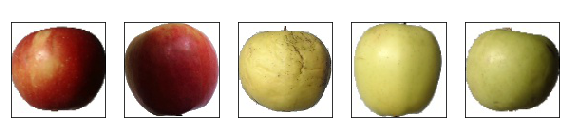

In [10]:
show_images(train_df, 5)

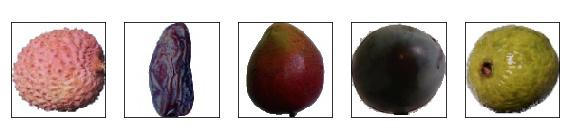

In [11]:
show_images(train_df, 5, shuffle=True)

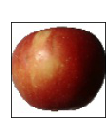

In [12]:
show_images(train_df, n_per_class=1, classes=0)

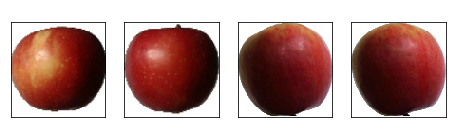

In [13]:
show_images(train_df, n_per_class=2, classes=[0,1])

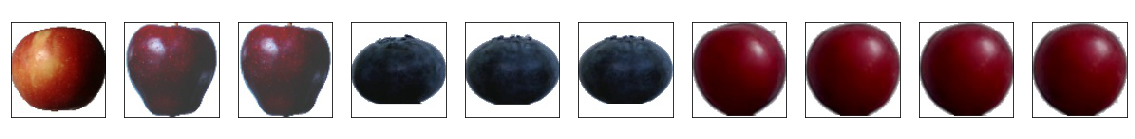

In [14]:
show_images(train_df, n_per_class=[1,2,3,4], classes=[0,10,20,30])

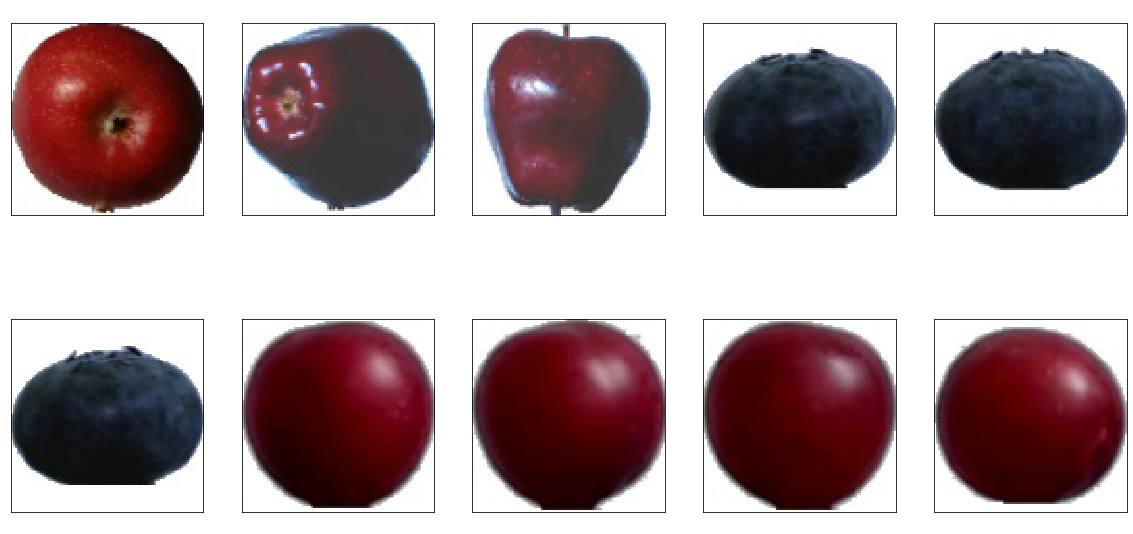

In [15]:
show_images(train_df, n_per_class=[1,2,3,4], classes=[0,10,20,30], shuffle=True, layout=(2,5))

## Varieties of fruit

In [16]:
fruit_variety = train_df.set_index('class_idx')['class_name'].drop_duplicates().str.split(' ', 1, expand=True).reset_index()
fruit_variety.columns = ["class_idx", "base_fruit", "variety"]
fruit_variety.index = pd.MultiIndex.from_frame(fruit_variety[['base_fruit','class_idx']])
fruit_variety = fruit_variety.drop(['class_idx', 'base_fruit'], axis=1)
fruit_variety

variety
base_fruit class_idx              
Apple      0              Braeburn
           1          Crimson Snow
           2              Golden 1
           3              Golden 2
           4              Golden 3
...                            ...
Tomato     126              Maroon
           127         not Ripened
           128              Yellow
Walnut     129                None
Watermelon 130                None

[131 rows x 1 columns]

In [21]:
fruit_variety.reset_index()

base_fruit  class_idx       variety
0         Apple          0      Braeburn
1         Apple          1  Crimson Snow
2         Apple          2      Golden 1
3         Apple          3      Golden 2
4         Apple          4      Golden 3
..          ...        ...           ...
126      Tomato        126        Maroon
127      Tomato        127   not Ripened
128      Tomato        128        Yellow
129      Walnut        129          None
130  Watermelon        130          None

[131 rows x 3 columns]

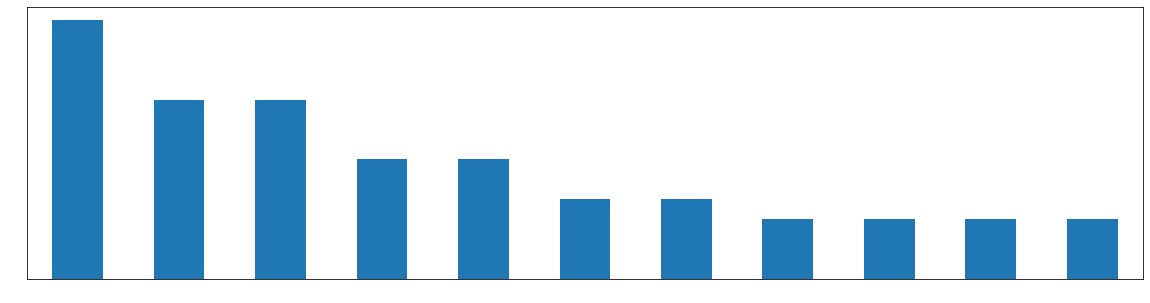

In [22]:
varieties = fruit_variety.reset_index()['base_fruit'].value_counts()
varieties[varieties > 2].plot(kind="bar", figsize=(20,5), rot=0, yticks=range(0, max(varieties)+1));

### Show one image per variety of Apple

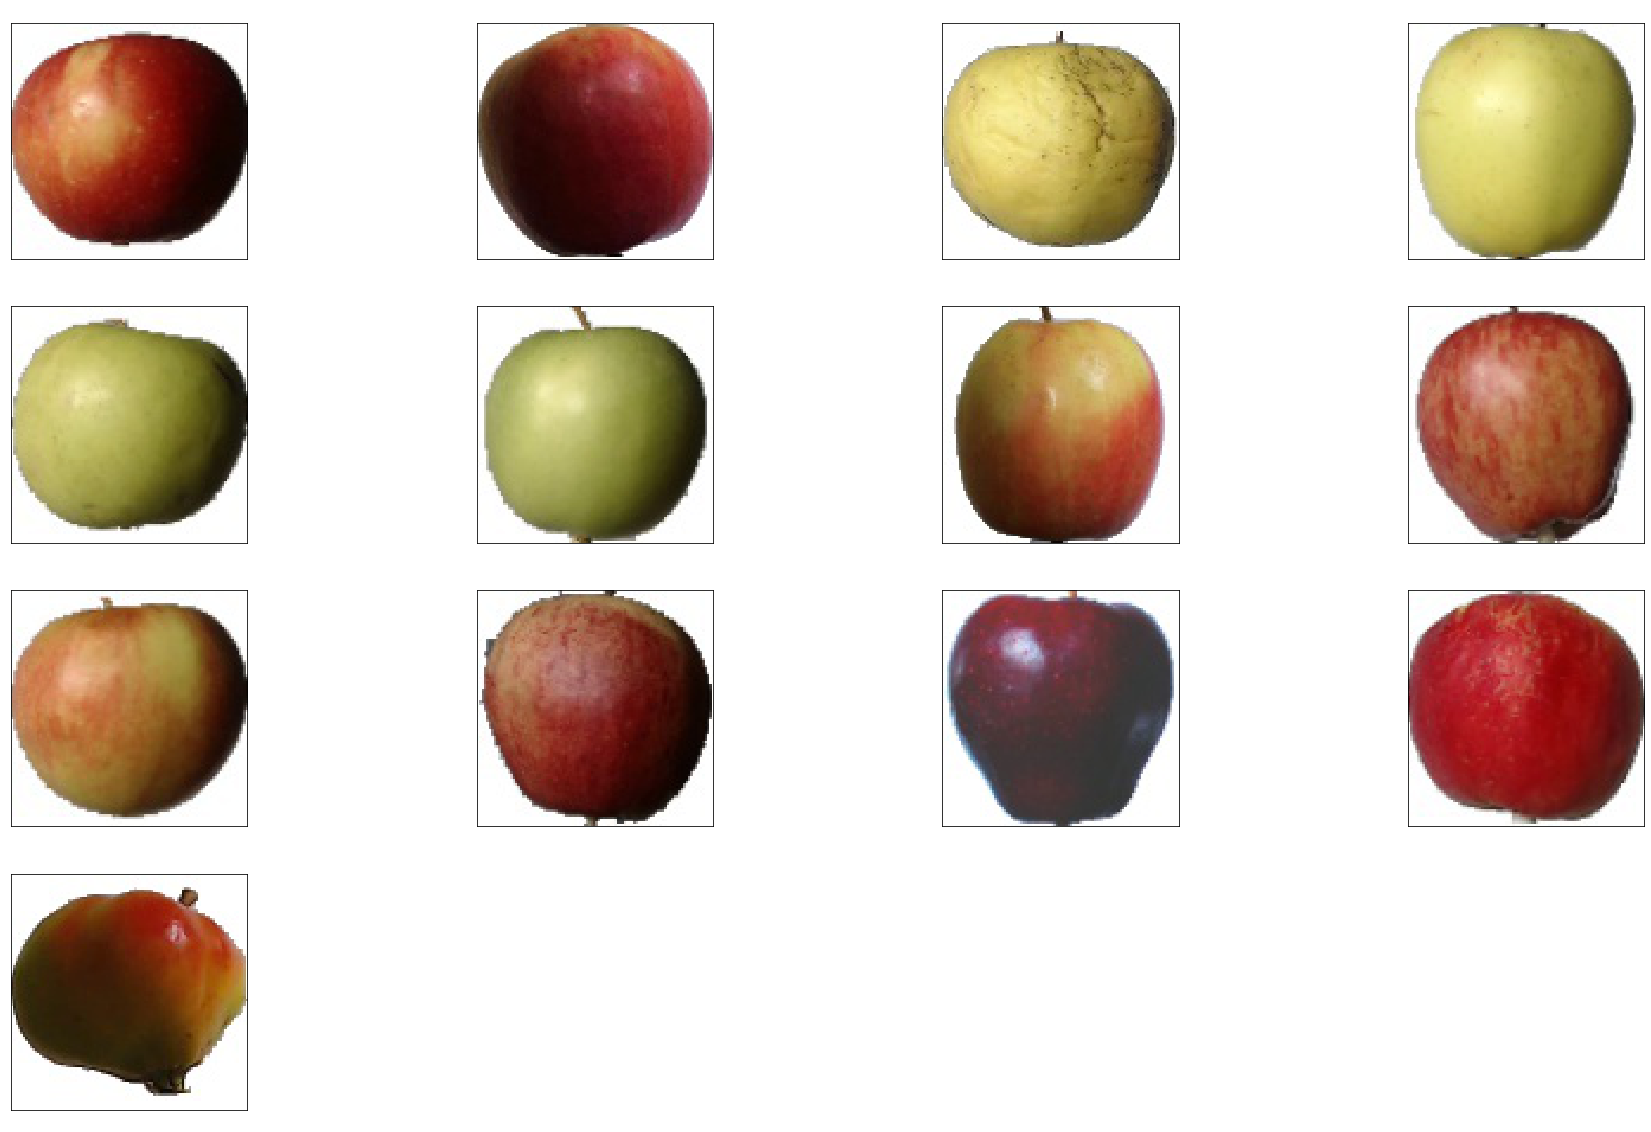

In [23]:
show_images(train_df, n_per_class=1, classes=fruit_variety.loc['Apple'].index, layout=(4,4))

### Show one image per variety of Tomato

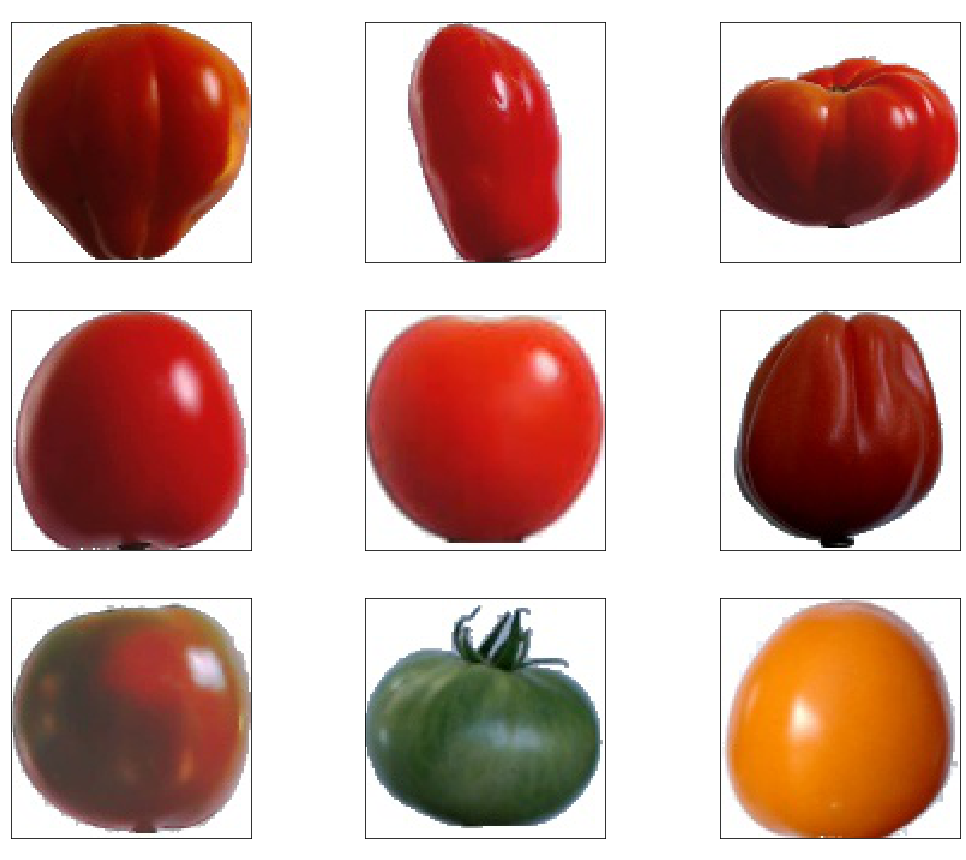

In [24]:
show_images(train_df, n_per_class=1, classes=fruit_variety.loc['Tomato'].index, layout=(3,3))

### Show one image per variety of Pear

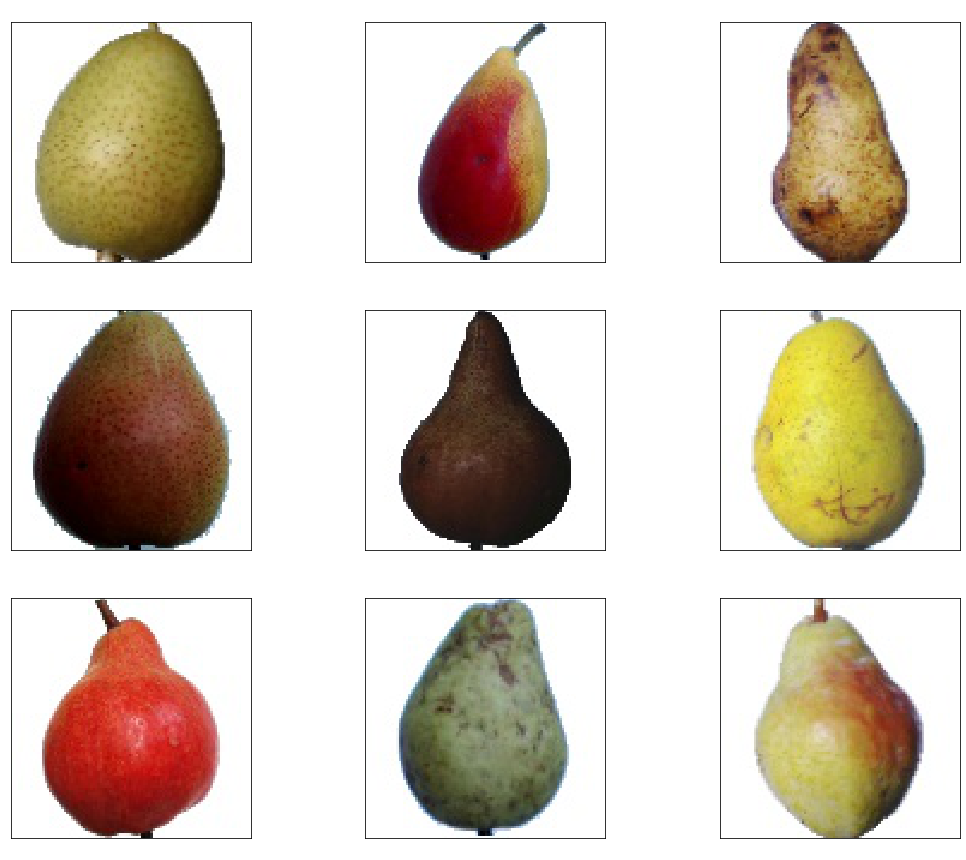

In [25]:
show_images(train_df, n_per_class=1, classes=fruit_variety.loc['Pear'].index, layout=(3,3))

## Visualize the distribution of fruit categories

In [31]:
df_counts = pd.concat([train_df['class_name'].value_counts().sort_index(), test_df['class_name'].value_counts().sort_index()], axis=1)
df_counts.columns = ["Training", "Test"]
df_counts

Training  Test
Apple Braeburn           492   164
Apple Crimson Snow       444   148
Apple Golden 1           480   160
Apple Golden 2           492   164
Apple Golden 3           481   161
...                      ...   ...
Tomato Maroon            367   127
Tomato Yellow            459   153
Tomato not Ripened       474   158
Walnut                   735   249
Watermelon               475   157

[131 rows x 2 columns]

### Total images

Training    67692
Test        22688
dtype: int64


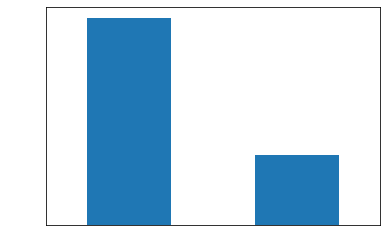

In [32]:
print(df_counts.sum())
df_counts.sum().plot(kind="bar", rot=0);

In [33]:
df_counts.sum().sum()

90380

### Plot the distribution of images per fruit category

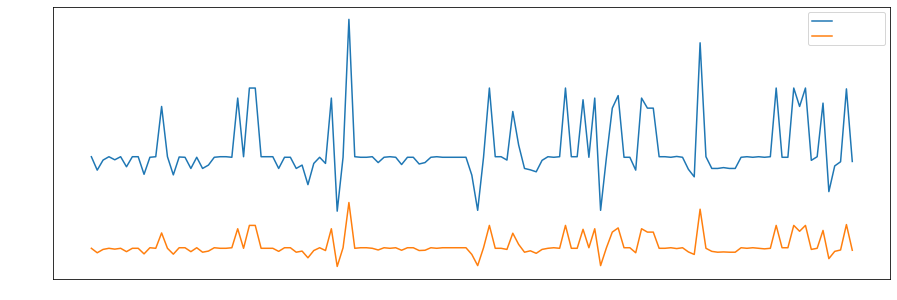

In [34]:
ax = df_counts.plot(figsize=(15,5), xticks=[])
ax.set_xlabel("Categories"); ax.set_ylabel("Counts");

In [35]:
round((df_counts["Training"]/df_counts["Test"]).mean())

3.0

From the plot, we can see that the test images and training images are in proportion, which suggests that the initial dataset was combined and for users convenience, it has been split by a ratio of <b>Train:Test :: 3:1<b>

### Top 5 and Bottom 5 categories according to number of images
Might require resampling to avoid ML model bias

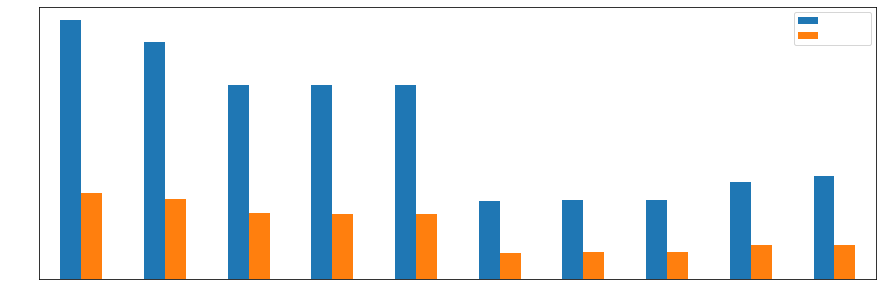

In [36]:
df_counts.sort_values("Test", ascending=False) \
.iloc[list(range(5))+list(range(-1,-6,-1))].plot(kind="bar", rot=0, figsize=(15,5));